# YandexgGPT results in Centipede game

In [1]:
! pip3 install pymorphy3

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('solo_results_llm_first_move.csv')

In [4]:
df.shape

(2162, 6)

In [5]:
df.sample(5)

,game,round,player,emotional_state,action,explanation
1301,3144b313-9b10-4423-a57e-6cce80c901a4,4,Пользователь_2,неважно,pass,без комментариев
1762,915bec1a-efdc-4b5f-99a5-f2d2584f1ad8,7,Пользователь_1,испуганный,pass,"\nиспуганный игрок может посчитать, что ему не..."
1447,39fb2ac2-ce85-4777-a259-3c1a8188549d,1,Пользователь_1,гневный,take,\n\nгнев может мотивировать человека на решите...
1190,b0fd0c66-6673-4872-86d0-66477b419de3,1,Пользователь_1,радостный,take,\n\nпоскольку сейчас первый раунд и оппонент м...
195,f1070320-9c29-4121-a6d5-8858422a5e63,4,Пользователь_2,неважно,pass,без комментариев


In [6]:
df['emotional_state'].unique()

array(['радостный', 'грустный', 'неважно', 'гневный', 'испуганный',
       'удивленный', 'злой', 'нейтральный'], dtype=object)

In [7]:
#### Можем выкинуть эти строки, так как они не влияют на дальнейший анализ (по сути избавились от 2-го игрока)
df = df[df['emotional_state'] != 'неважно']

#### Число игр для каждого эмоционального состояния (проверить баланс классов)

In [8]:
games_per_emotional_state = df.groupby('emotional_state')['game'].nunique().reset_index()
games_per_emotional_state.columns = ['emotional_state', 'Number_of_Games']
print('Total number of games played: ', games_per_emotional_state['Number_of_Games'].sum())
games_per_emotional_state

Total number of games played:  661


,emotional_state,Number_of_Games
0,гневный,91
1,грустный,100
2,злой,100
3,испуганный,100
4,нейтральный,90
5,радостный,85
6,удивленный,95


#### Максимальное число раундов для каждого эмоционального состояния

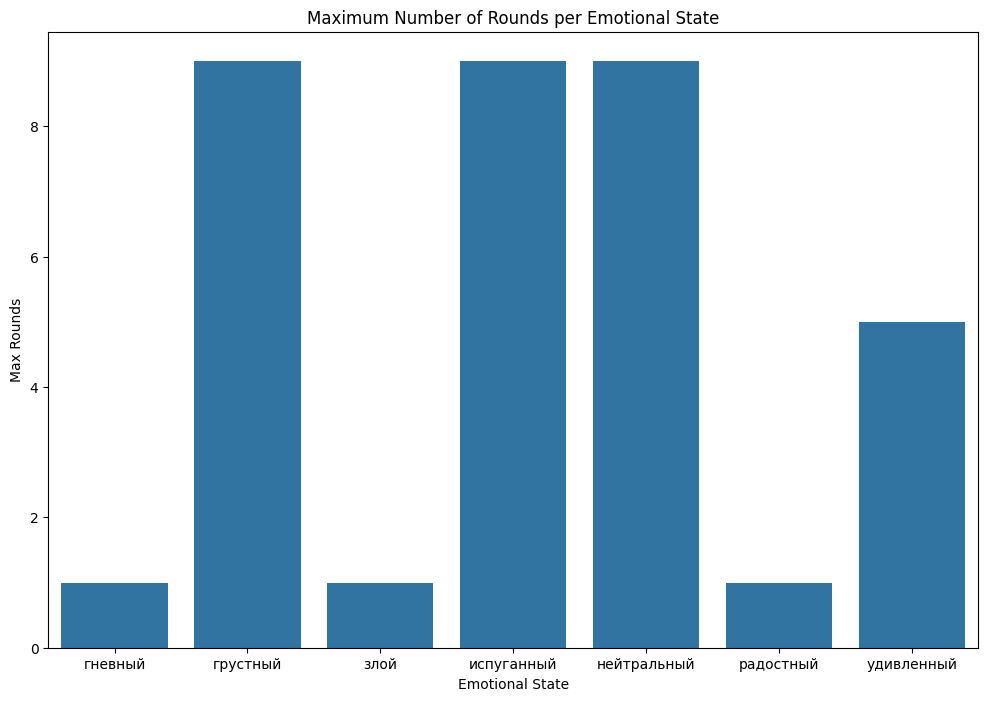

In [9]:
max_rounds_per_emotional_state = df.groupby('emotional_state')['round'].max().reset_index()
max_rounds_per_emotional_state.columns = ['emotional_state', 'max_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=max_rounds_per_emotional_state, x='emotional_state', y='max_round')
plt.title('Maximum Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Max Rounds')
plt.show()

#### Среднее число раундов для каждого эмоционального состояния

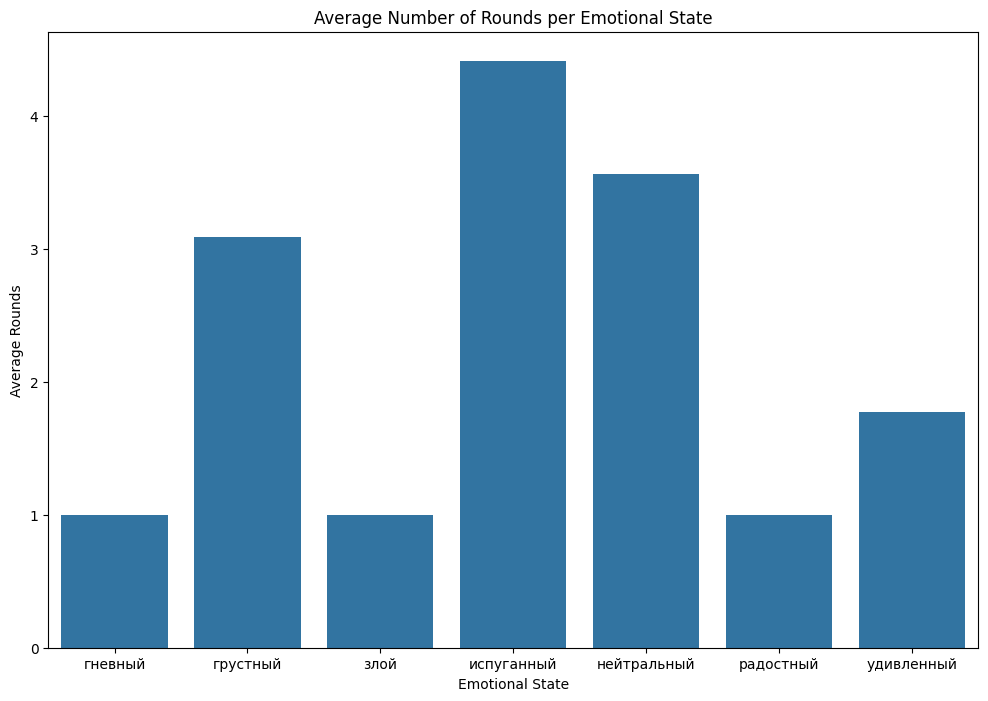

In [10]:
avg_rounds_per_emotional_state = df.groupby('emotional_state')['round'].mean().reset_index()
avg_rounds_per_emotional_state.columns = ['emotional_state', 'avg_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=avg_rounds_per_emotional_state, x='emotional_state', y='avg_round')
plt.title('Average Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Average Rounds')
plt.show()

In [11]:
avg_rounds_per_emotional_state

,emotional_state,avg_round
0,гневный,1.000000
1,грустный,3.091873
2,злой,1.000000
3,испуганный,4.415313
4,нейтральный,3.562278
5,радостный,1.000000
6,удивленный,1.771429


#### Медианное число раундов для каждого эмоционального состояния

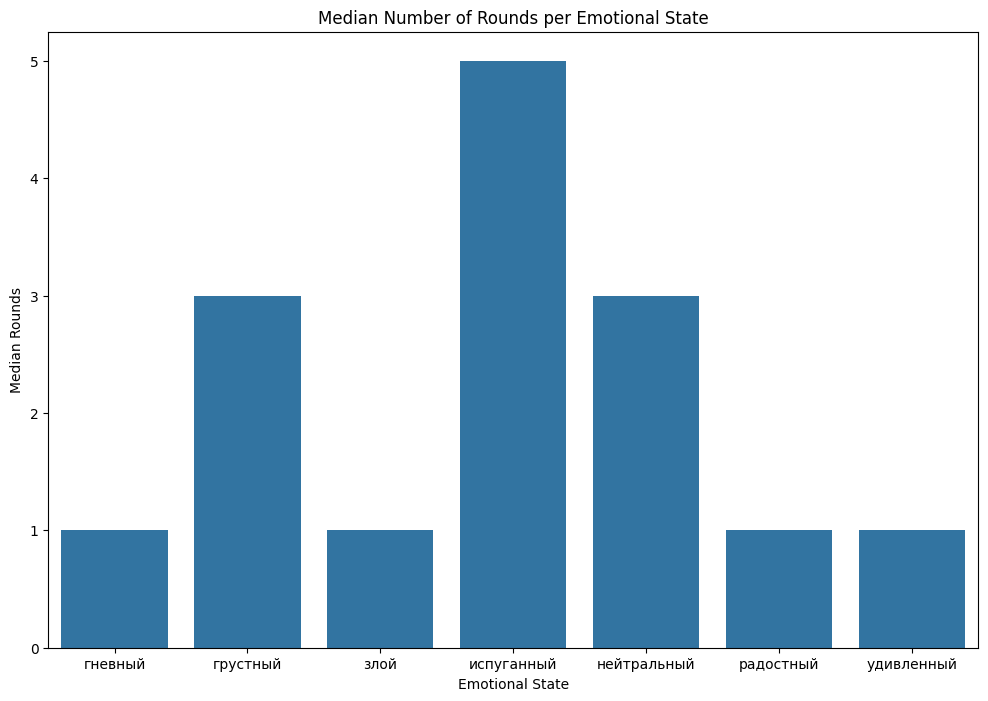

In [12]:
median_rounds_per_emotional_state = df.groupby('emotional_state')['round'].median().reset_index()
median_rounds_per_emotional_state.columns = ['emotional_state', 'median_round']

plt.figure(figsize=(12, 8))
sns.barplot(data=median_rounds_per_emotional_state, x='emotional_state', y='median_round')
plt.title('Median Number of Rounds per Emotional State')
plt.xlabel('Emotional State')
plt.ylabel('Median Rounds')
plt.show()

# Analysis

In [13]:
df_grouped = df.groupby('emotional_state')['explanation'].apply(lambda x: ' '.join(x)).reset_index()

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

nltk.download('stopwords')
stop_words = set(stopwords.words('russian') + ['это'])
morph = MorphAnalyzer()

def preprocess_text(text):
    text = text.lower()
    # Убираем пунктуацию и числа
    text = re.sub(r'\W+', ' ', text)

    words = text.split()
    words = [morph.normal_forms(word)[0] for word in words if word not in stop_words]
    return ' '.join(words)

df_grouped['cleaned_explanation'] = df_grouped['explanation'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])
cosine_similarities = cosine_similarity(X, X)

similarity_df = pd.DataFrame(cosine_similarities, index=df_grouped['emotional_state'], columns=df_grouped['emotional_state'])

def get_similar_emotional_states(similarity_df, threshold=0.5):
    similar_states = []
    for i in range(len(similarity_df)):
        for j in range(i+1, len(similarity_df)):
            if similarity_df.iloc[i, j] > threshold:
                similar_states.append((similarity_df.index[i], similarity_df.index[j], similarity_df.iloc[i, j]))
    return similar_states

similar_states = get_similar_emotional_states(similarity_df, threshold=0.01)

In [16]:
similar_states

[('гневный', 'грустный', 0.6916275955715585),
 ('гневный', 'злой', 0.7221739503277865),
 ('гневный', 'испуганный', 0.5021583550174648),
 ('гневный', 'нейтральный', 0.7157023402538325),
 ('гневный', 'радостный', 0.7600066789984024),
 ('гневный', 'удивленный', 0.7299245799140148),
 ('грустный', 'злой', 0.707234347108738),
 ('грустный', 'испуганный', 0.6567440365331884),
 ('грустный', 'нейтральный', 0.9053331581904615),
 ('грустный', 'радостный', 0.7692146243233212),
 ('грустный', 'удивленный', 0.8283420621207741),
 ('злой', 'испуганный', 0.512851794690434),
 ('злой', 'нейтральный', 0.7430193853864929),
 ('злой', 'радостный', 0.7634343029099492),
 ('злой', 'удивленный', 0.747667445218563),
 ('испуганный', 'нейтральный', 0.6562466745803671),
 ('испуганный', 'радостный', 0.5432994563252425),
 ('испуганный', 'удивленный', 0.6087517314220539),
 ('нейтральный', 'радостный', 0.8217218077311015),
 ('нейтральный', 'удивленный', 0.8718247384337245),
 ('радостный', 'удивленный', 0.8036095308324874)

#### Что происходит внутри эмоционального класса?

#### Нужно переписать!

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_grouped['cleaned_explanation'])

feature_names = vectorizer.get_feature_names_out()

tfidf_sums = X.sum(axis=0).A1

tfidf_df = pd.DataFrame({'term': feature_names, 'tfidf_sum': tfidf_sums})

tfidf_df = tfidf_df.sort_values(by='tfidf_sum', ascending=False)

top_n = 15
top_terms = tfidf_df.head(top_n)

In [18]:
top_terms

,term,tfidf_sum
312,монета,3.180597
825,стопка,2.383819
711,раунд,1.821773
210,игра,1.589996
41,больший,1.235116
70,взять,1.217818
431,оппонент,1.088398
480,первый,0.975791
538,получить,0.938237
213,игрок,0.845248


# LLM vs LLM

In [19]:
df = pd.read_csv('duo_results_llm_vs_llm.csv')

In [20]:
df.sample(5)

,game,round,player,emotional_state,action,explanation
1673,99522106-72d9-46f7-8686-f3174b4d0705,1,Пользователь_1,"('нейтральный', 'удивленный')",pass,\n\nна первом ходу лучше не рисковать и переда...
1601,3deef379-cc14-47e6-bb37-c2fdc69bc691,3,Пользователь_1,"('нейтральный', 'испуганный')",take,\n\nв начале третьего раунда у игрока 1 две ст...
218,1beae4e9-057f-40d4-b055-a996d80541db,2,Пользователь_2,"('грустный', 'радостный')",take,\n\nтак как мой оппонент в первом раунде выбра...
834,54dbd5ed-8e56-4fae-86d8-8fc624fc08a9,2,Пользователь_2,"('испуганный', 'гневный')",take,\n\nисходя из условий игры и эмоционального со...
117,cf8a21c0-9441-4e16-b219-fb39944c5b5a,1,Пользователь_1,"('радостный', 'испуганный')",take,\n\nрадостный игрок с большей вероятностью выб...


#### Матрица максимального раунда для каждой пары эмоций

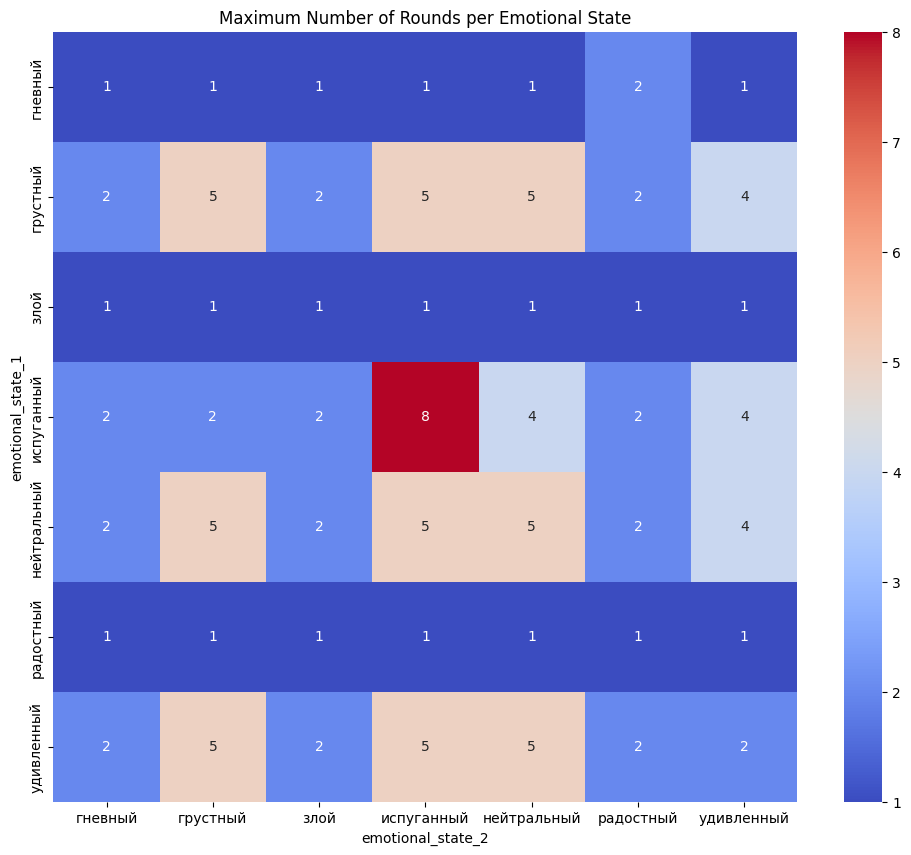

In [21]:
grouped = df.groupby('emotional_state')['round'].max().reset_index()
grouped.columns = ['emotional_state', 'max_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='max_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm')
plt.title('Maximum Number of Rounds per Emotional State')
plt.show()


#### Матрица максимального раунда для каждой пары эмоций

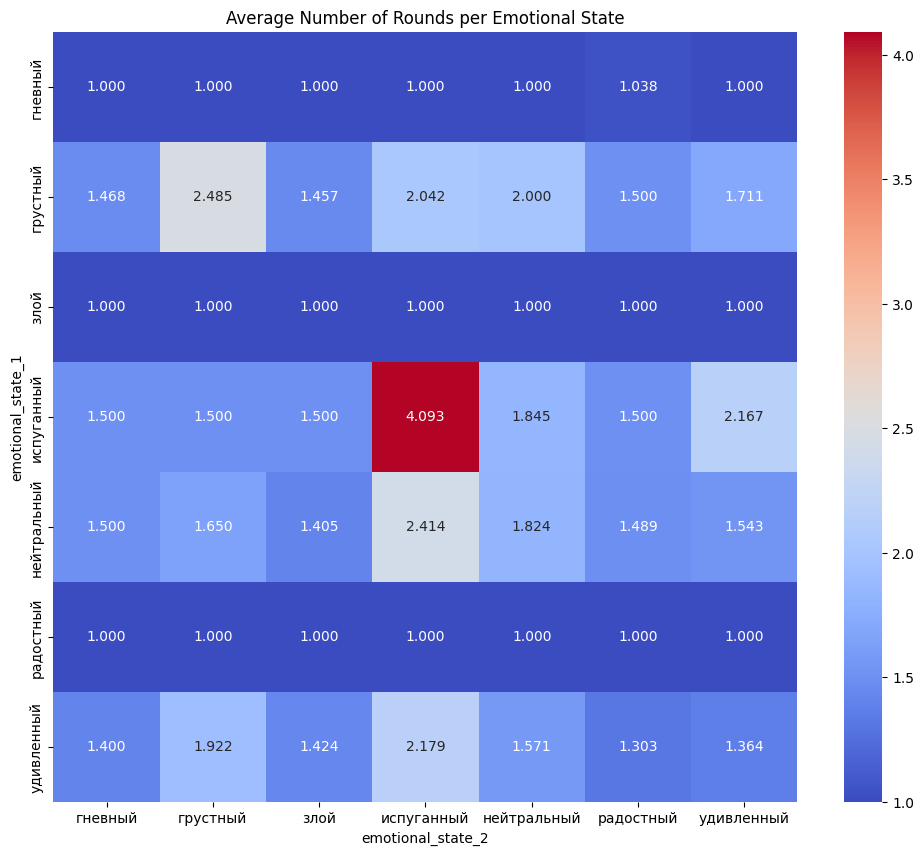

In [22]:
grouped = df.groupby('emotional_state')['round'].mean().reset_index()
grouped.columns = ['emotional_state', 'avg_round']

grouped['emotional_state_1'] = grouped['emotional_state'].apply(lambda x: x.split(',')[0][2:-1])
grouped['emotional_state_2'] = grouped['emotional_state'].apply(lambda x: x.split(', ')[1][1:-2])

matrix = grouped.pivot(index='emotional_state_1', columns='emotional_state_2', values='avg_round')

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('Average Number of Rounds per Emotional State')
plt.show()

